In [1]:
import keras
from keras import layers, regularizers
from keras.callbacks import EarlyStopping
import pandas as pd
from os import path, listdir
import numpy as np

import matplotlib.pyplot as plt

2025-10-16 08:23:53.438505: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv(path.join('./data', 'prices.csv'), delimiter = ';', date_format='%d/%m/%Y', parse_dates = ['date'])
df.head()

,date,open,close,low,high,volume
0,2016-05-01,123.430000,125.839996,122.309998,126.250000,2163600
1,2016-05-02,125.239998,119.980003,119.940002,125.540001,2386400
2,2016-05-03,116.379997,114.949997,114.930000,119.739998,2489500
3,2016-05-04,115.480003,116.620003,113.500000,117.440002,2006300
4,2016-05-05,117.010002,114.970001,114.089996,117.330002,1408600


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3379 entries, 0 to 3378
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3379 non-null   datetime64[ns]
 1   open    3379 non-null   float64       
 2   close   3379 non-null   float64       
 3   low     3379 non-null   float64       
 4   high    3379 non-null   float64       
 5   volume  3379 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 158.5 KB


In [4]:
round(78.53)

79

In [5]:

train_to_idx = round(df.shape[0] * 0.7) + 1

In [6]:
ts = (
    df
    .set_index(['date'])
    .loc[:,['open']]
)
ts.head()

,open
date,
2016-05-01,123.430000
2016-05-02,125.239998
2016-05-03,116.379997
2016-05-04,115.480003
2016-05-05,117.010002


In [7]:
def create_ts_series (data, steps):
    
    X, y = list(), list()
    
    for i in range(len(data) - steps):
        X.append(data[i:(i+steps)])
        y.append(data[i+steps])
    
    return np.array(X), np.array(y)

In [44]:
reshape_test = ts.to_numpy()[:,0]
n_steps = 60
X, y = create_ts_series(reshape_test, n_steps) 

In [45]:
n_samples = y.shape[0]
n_samples

3319

In [46]:
X_train = X[:train_to_idx, :].copy()
y_train = y[:train_to_idx].copy()
X_test = X[train_to_idx:, :].copy()
y_test = y[train_to_idx:].copy()

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

Dt_train = scaler.fit_transform(np.column_stack((X_train, y_train.reshape(-1, 1))))
Dt_test = scaler.transform(np.column_stack((X_test, y_test.reshape(-1, 1))))
X_train, y_train = Dt_train[:, :n_steps], np.squeeze(Dt_train[:, n_steps]) 
X_test, y_test = Dt_test[:, :n_steps], np.squeeze(Dt_test[:, n_steps]) 

In [48]:
n_train_samples, n_test_samples, n_steps, n_features = X_train.shape[0], X_test.shape[0], X.shape[1], 1
X_train = X_train.reshape((n_train_samples, n_steps, n_features))
X_test = X_test.reshape((n_test_samples, n_steps, n_features))

In [63]:
lstm_model = keras.Sequential()

lstm_model.add(layers.Input(shape = (n_steps, n_features)))
lstm_model.add(layers.LSTM(units=n_steps, kernel_regularizer=regularizers.l2(0.2)))
lstm_model.add(layers.Dropout(0.2)) 
lstm_model.add(layers.Dense(units=1, activation='relu'))

lstm_model.compile(optimizer=keras.optimizers.Adam(learning_rate=.001), loss='mae', metrics=['mae'])

lstm_model.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 60)             │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,941 (58.36 KB)

 Trainable params: 14,941 (58.36 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train, y_train, batch_size=256, epochs=60, validation_data=(X_test, y_test), callbacks=[early_stop], shuffle=True)

Epoch 1/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.9133 - mae: 0.5343 - val_loss: 0.8380 - val_mae: 0.4989
Epoch 2/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.8101 - mae: 0.4961 - val_loss: 0.7753 - val_mae: 0.4960
Epoch 3/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.7519 - mae: 0.4941 - val_loss: 0.7238 - val_mae: 0.4941
Epoch 4/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.6960 - mae: 0.4847 - val_loss: 0.6766 - val_mae: 0.4898
Epoch 5/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.6525 - mae: 0.4806 - val_loss: 0.6375 - val_mae: 0.4860
Epoch 6/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.6165 - mae: 0.4773 - val_loss: 0.6081 - val_mae: 0.4853
Epoch 7/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.5873 - mae: 0.4747 - val_loss: 0.5847 - val_mae: 0.4853
Epoch 8/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.5657 - mae: 0.4747 - val_loss: 0.5653 - val_mae: 0.4853
Epoch 9/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.54

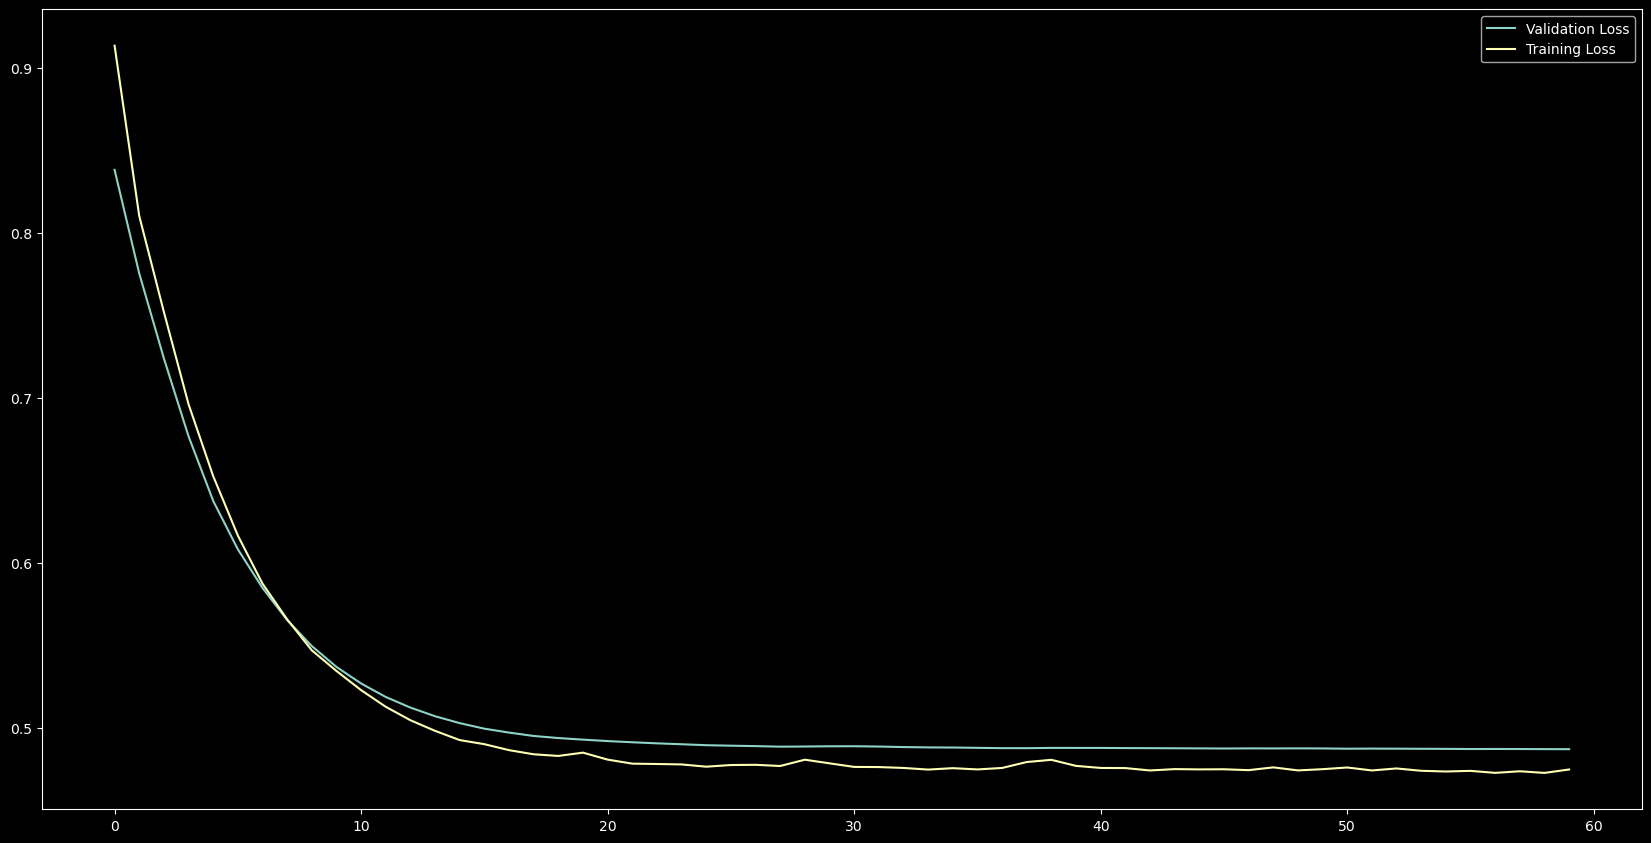

In [65]:
history = lstm_model.history


fig = plt.figure(figsize=(16, 8))

ax = fig.add_axes(rect=(0,0,1,1))

ax.plot(history.history['val_loss'], label = 'Validation Loss')
ax.plot(history.history['loss'], label = 'Training Loss')
ax.legend()

In [67]:
test_loss, test_mea = lstm_model.evaluate(X_test, y_test)
print(test_loss, test_mea)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4870 - mae: 0.4853
0.4870046377182007 0.48531976342201233


In [84]:
y_pred = lstm_model.predict_step(X_test)

In [85]:
y_pred

<tf.Tensor: shape=(953, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
 

In [80]:
Dt_pred = scaler.inverse_transform(np.column_stack((X_test.squeeze(), y_pred)))
y_pred = np.squeeze(Dt_pred[:, n_steps]) 

/tmp/ipykernel_14291/3605503701.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


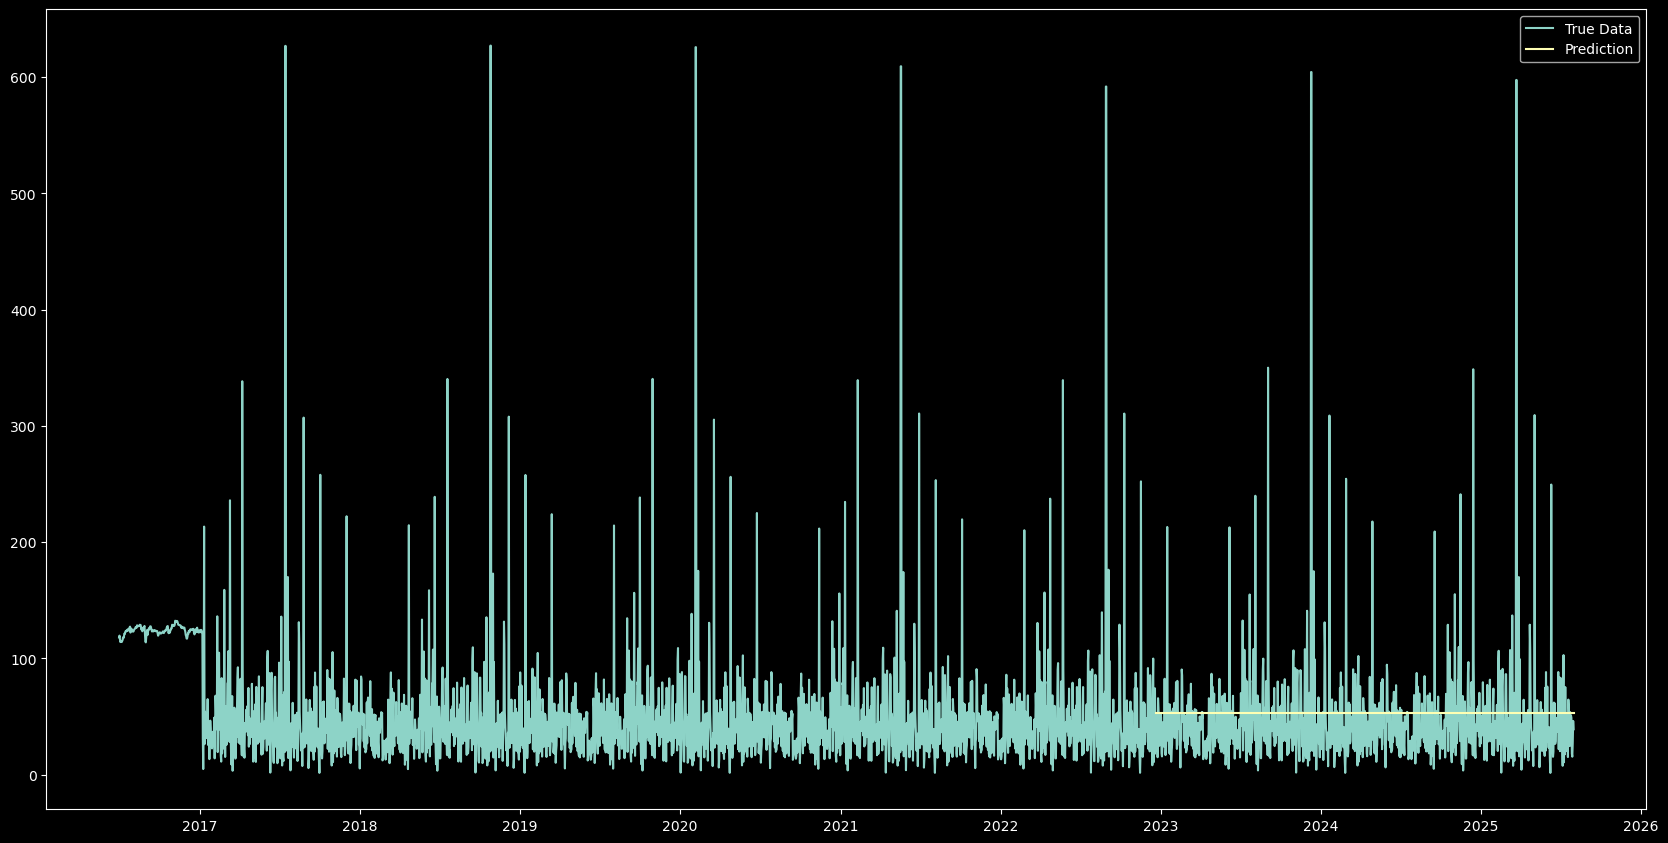

In [83]:
y = np.concat((y_train, y_test))

fig = plt.figure(figsize=(16, 8))

ax = fig.add_axes(rect=(0,0,1,1))

ax.plot(ts.index[n_steps:], ts.loc[ts.index[n_steps:], :], label = 'True Data',)
ax.plot(ts.index[(n_steps + train_to_idx):], y_pred, label = 'Prediction')
ax.legend()
fig.show()